In [2]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

# import re
# import astropy.units as u
# from scipy.spatial import cKDTree
from numba import njit, prange
# from scipy.interpolate import interp1d
# import matplotlib as mpl
# from scipy.optimize import root_scalar
import glob
# import agama

# from pyMND.forcetree import construct_tree, force_treeevaluate_loop

# from rbf.interpolate import KNearestRBFInterpolant
# from sklearn.cluster import KMeans
from joblib import Parallel, delayed

time_conv = 977.79222167
G = 43018.7

In [3]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=None, 
              fields=['Coordinates', 'Masses', 'Velocities', 'Acceleration'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

In [47]:
idx = 300
sn = read_snap(idx, 1, lvl='lvl3', fields=None, parttype=[0])
sn301 = read_snap(idx+1, 1, lvl='lvl3', fields=None, parttype=[0])
sn350 = read_snap(350, 1, lvl='lvl3', fields=None, parttype=[0])
# snN = read_snap(idx, 0, lvl='lvl3')

In [41]:
@njit 
def compute_mass_inflow(R, vR, mass, Rbins):
    key = np.where(R < Rbins[-1])[0]
    R = R[key]
    vR = vR[key]
    mass = mass[key]
    
    surface_dens = np.zeros(len(Rbins)-1)
    ave_R = np.zeros(len(Rbins)-1)
    N_in_bin = np.zeros(len(Rbins)-1)
    
    for i in range(len(R)):
        for j in range(len(Rbins)-1):
            if R[i] >= Rbins[j] and R[i] < Rbins[j+1]:
                ave_R[j] += R[i]
                N_in_bin[j] += 1
                mass_inflow[j] += mass[i] * vR[i]
    
    for j in range(len(Rbins)-1):
        if N_in_bin[j] > 0:
            ave_R[j] /= N_in_bin[j]
            mass_inflow[j] /= Rbins[j+1] - Rbins[j]
        else:
            ave_R[j] = np.nan
            mass_inflow[j] = np.nan
    
    return ave_R, mass_inflow

def compute_mass_inflow_from_sn(sn, Rbins, center=np.array([200., 200., 200.])):
    
    gas_pos = sn.part0.pos.value - center
    gas_vel = sn.part0.vel.value
    gas_mass = sn.part0.mass.value

    R = np.linalg.norm(gas_pos[:,:2], axis=1)
    phi = np.arctan2(gas_pos[:,1], gas_pos[:,0])

    vR = gas_vel[:,1] * np.sin(phi) + gas_vel[:,0] * np.cos(phi)
    
    ave_R, Mdot = compute_mass_inflow(R, vR, gas_mass, Rbins)
    
    return ave_R, Mdot
    

In [52]:
Rbins = np.linspace(0, 12, 30)
R_Mdot, Mdot = compute_mass_inflow_from_sn(sn, Rbins)
R_Mdot1, Mdot1 = compute_mass_inflow_from_sn(sn301, Rbins)
R_Mdot50, Mdot50 = compute_mass_inflow_from_sn(sn350, Rbins)

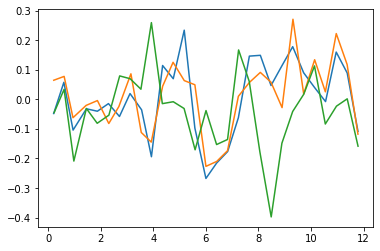

In [53]:
plt.plot(R_Mdot, Mdot)
plt.plot(R_Mdot1, Mdot1)
plt.plot(R_Mdot50, Mdot50)
plt.show()

In [55]:
Rbins = np.linspace(0, 12, 30)

idx_list = np.arange(300, 310)

ave_R = np.zeros(len(Rbins)-1)
ave_Mdot = np.zeros(len(Rbins)-1)

for idx in tqdm(idx_list):
    sn = read_snap(idx, 1, lvl='lvl3', fields=['Coordinates', 'Velocities', 'Masses'], parttype=[0])
    
    R, Mdot = compute_mass_inflow_from_sn(sn, Rbins)
    
    ave_R += R
    ave_Mdot += Mdot

ave_R /= len(idx_list)
ave_Mdot /= len(idx_list)
    

A Jupyter Widget

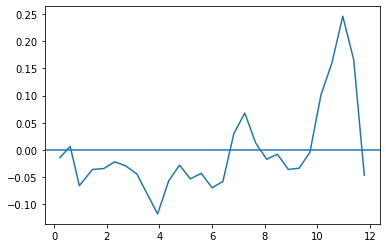

In [57]:
plt.plot(ave_R, ave_Mdot)
plt.axhline(0)
plt.show()

In [60]:
Rbins = np.linspace(0, 12, 30)

idx_list = np.arange(100, 120)

ave_R100 = np.zeros(len(Rbins)-1)
ave_Mdot100 = np.zeros(len(Rbins)-1)

for idx in tqdm(idx_list):
    sn = read_snap(idx, 1, lvl='lvl3', fields=['Coordinates', 'Velocities', 'Masses'], parttype=[0])
    
    R, Mdot = compute_mass_inflow_from_sn(sn, Rbins)
    
    ave_R100 += R
    ave_Mdot100 += Mdot

ave_R100 /= len(idx_list)
ave_Mdot100 /= len(idx_list)
    

A Jupyter Widget

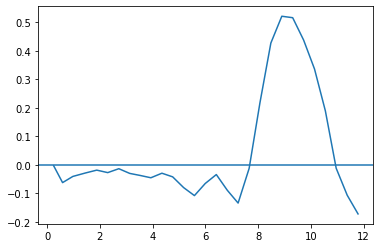

In [61]:
plt.plot(ave_R100, ave_Mdot100)
plt.axhline(0)
plt.show()

In [64]:
Rbins = np.linspace(0, 12, 30)

idx_list = np.arange(140, 158)

ave_R100 = np.zeros(len(Rbins)-1)
ave_Mdot100 = np.zeros(len(Rbins)-1)

for idx in tqdm(idx_list):
    sn = read_snap(idx, 1, lvl='lvl3-GFM', fields=['Coordinates', 'Velocities', 'Masses'], parttype=[0])
    
    R, Mdot = compute_mass_inflow_from_sn(sn, Rbins)
    
    ave_R100 += R
    ave_Mdot100 += Mdot

ave_R100 /= len(idx_list)
ave_Mdot100 /= len(idx_list)
    

A Jupyter Widget

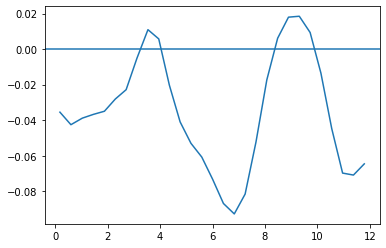

In [65]:
plt.plot(ave_R100, ave_Mdot100)
plt.axhline(0)
plt.show()